# ノート

磁場は長岡係数 $K_n$ による補正が必要である
$$
    H = K_N nI
$$

# コード

## ライブラリのインポート

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from scipy.signal import savgol_filter
import os
from scipy.optimize import curve_fit

## 測定値の取り込み

In [3]:
def get_length(N):
    if(N == 50):
        L = 7.478
    elif(N == 75):
        L = 7.866
    if(N == 100):
        L = 7.238
    if(N == 150):
        L = 8.275
    return L

def get_Nagaoka_const(N):
    Kn = 1
    if(N == 50):
        # 2r = 2.200
        # 2r/L = 0.294
        Kn = 0.88584414
    elif(N == 75):
        # 2r = 2.2825
        # 2r/L = 0.290
        Kn = 0.88726387
    if(N == 100):
        # 2r = 2.200
        # 2r/L = 0.304
        Kn = 0.88241768
    if(N == 150):
        # 2r = 2.200
        # 2r/L = 0.266
        Kn = 0.89592395
    return Kn

def calc_H(N, V):
    R = 0.1 # 抵抗
    Kn = get_Nagaoka_const(N)
    L = get_length(N)

    H = Kn * N * V / L / R # 単位 A/cm

    return H/1000 # 単位 kA/cm


Ns = np.array([150, 150, 150, 150,
        100, 100, 100, 100,
        75,  75, 75, 75,
        50, 50, 50, 50,
        150, 150, 150, 150, 150,
        150, 150, 150, 150, 150])

Vs = np.array([400, 300, 200, 100,
            400, 300, 200, 100,
            400, 300, 200, 100,
            400, 300, 200, 100,
            400, 300, 200, 100, 100,
            400, 300, 200, 100, 100])

Time = np.linspace(-0.00005, 0.0004498, 2500) * 10 ** 6
dt = 0.2


nfile = 26
raw_data = np.zeros((nfile, 2, 2500))

Intensity = np.zeros((nfile, 2500))
H_field = np.zeros((nfile, 2500))

windowsize = 100
Intensity_smooth = np.zeros((nfile, 2500))
H_field_smooth = np.zeros((nfile, 2500))

for i in range(1, nfile+1):

    # 光の強さ
    ch1 = pd.read_csv(f"12_05/ALL{i:04}/F{i:04}CH1.CSV", header=None, usecols = [4]).to_numpy()[:,0]

    # 磁場の強さ 16 番目のデータだけ破損している
    if(i != 16):
        ch2 = pd.read_csv(f"12_05/ALL{i:04}/F{i:04}CH2.CSV", header=None, usecols = [4]).to_numpy()[:,0]
    else :
        ch2 = pd.read_csv(f"12_05/ALL{i-1:04}/F{i-1:04}CH2.CSV", header=None, usecols = [4]).to_numpy()[:,0]/2

    raw_data[i-1][0] = ch1
    raw_data[i-1][1] = ch2

    Intensity[i-1] = (ch1-np.min(ch1))/(np.max(ch1)-np.min(ch1))
    H_field[i-1] = calc_H(Ns[i-1], ch2)

    Intensity_smooth[i-1] = savgol_filter(Intensity[i-1], window_length = windowsize, polyorder = 5)
    H_field_smooth[i-1] = savgol_filter(H_field[i-1], window_length = windowsize, polyorder = 5)
del i

## 出力

### X-T グラフ

In [4]:
font_size = 18

def plot_xt_graph(index):
    f = plt.figure()

    ax1 = f.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax1.set_xlim(-50,450)
    ax1.set_ylim(0,1.0)

    ax1.set_xlabel("Time $t$ ($\mathrm{\mu s}$)")
    ax1.set_ylabel("Intensity $I(t)$ (arb. unit)")

    ax1.plot(Time, Intensity_smooth[index], c = "tab:blue", label="$I(t)$")
    ax1.scatter(Time, Intensity[index], s = 0.1, c = "tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Magnetic field $H(t)$ (kA/cm)")

    ax2.plot(Time, H_field_smooth[index], c = "tab:orange", label = "$H(t)$")
    ax2.scatter(Time, H_field[index], s = 0.1, c = "tab:orange")

    plt.title(f"$N$ = {Ns[index]}, $V$ = {Vs[index]}")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right')

    path = f"../image/xt/"
    if not os.path.isdir(path):
        os.makedirs(path)

    plt.savefig(f"../image/xt/{index+1:02}.png",  bbox_inches='tight')
    plt.close()


for i in range(nfile):
    plot_xt_graph(i)

### X-Y グラフ

In [86]:
def get_shift(N):
    if(N == 50):
        shift = 13
    elif(N == 75):
        shift = 14
    if(N == 100):
        shift = 19
    if(N == 150):
        shift = 24
    return shift


def plot_xy_graph(index, is_save=False):
    f = plt.figure()

    ax1 = f.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax1.set_xlim(0,8)
    ax1.set_ylim(0,1.0)

    ax1.set_xlabel("$H$ (kA/cm)")
    ax1.set_ylabel("Intensity $I(H)$ (arb. unit)")

    ax1.plot(H_field_smooth[index], Intensity_smooth[index], c = "tab:blue", label = "no fixed")
    ax1.scatter(H_field[index], Intensity[index], s = 0.1, c = "tab:blue")

    shift = get_shift(Ns[index])

    ax1.plot(H_field_smooth[index][:2500-shift], Intensity_smooth[index][shift:], c = "tab:orange", label = "fixed")
    ax1.scatter(H_field[index][:2500-shift], Intensity[index][shift:], s = 0.1, c = "tab:orange")

    def fu(x, a,b,c,d):
        y = b*np.cos(a*x+c)**2 + d
        return y
    bounds = ([0.7, 0.7, -np.pi, -0.5],[1.1, 1.5, np.pi, 0.5])
    popt, pcov = curve_fit(fu, H_field_smooth[index][:2500-shift], Intensity_smooth[index][shift:], bounds= bounds)
    ax1.plot(H_field_smooth[index],fu(H_field_smooth[index], *popt), c = "tab:green", label = "fitting")

    plt.title(f"$N$ = {Ns[index]}, $V$ = {Vs[index]}, delay = {shift*dt:1.1f} μs")

    plt.legend(loc = "upper right")
    if(is_save):
        path = f"../image/xy/"
        if not os.path.isdir(path):
            os.makedirs(path)

        plt.savefig(f"../image/xy/{index+1:02}.png",  bbox_inches='tight')
    plt.close()

    return popt[0]

def plot_verdet(is_save = False):
    f = plt.figure()
    ax1 = f.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax1.set_xlim(0,verdet.size)
    ax1.set_ylim(0,15)

    plt.xlabel("Measuremet Index")
    plt.ylabel("Verdet Const. (deg/kA)")

    plt.scatter(range(verdet.size),verdet)

    ave = 0

    if(verdet.size == nfile):
        ave = (np.sum(verdet[0:19])+np.sum(verdet[21:24]))/22
        ave = np.average(verdet)
        plt.hlines(ave, 0, verdet.size, color="tab:blue", label="ave. val")

    plt.hlines(10.4, 0, verdet.size, color="tab:orange", label="lit. values")

    plt.legend(loc = "lower right")

    if(is_save):
        plt.savefig(f"../image/verdet.png",  bbox_inches='tight')
        # plt.close()
    plt.show()

    return ave

In [ ]:
verdet = np.array([])
# for i in range(19,nfile):
for i in range(nfile):
    val = plot_xy_graph(i, True)
    val *= 36/np.pi
    verdet=np.append(verdet, val)

plot_verdet(True)

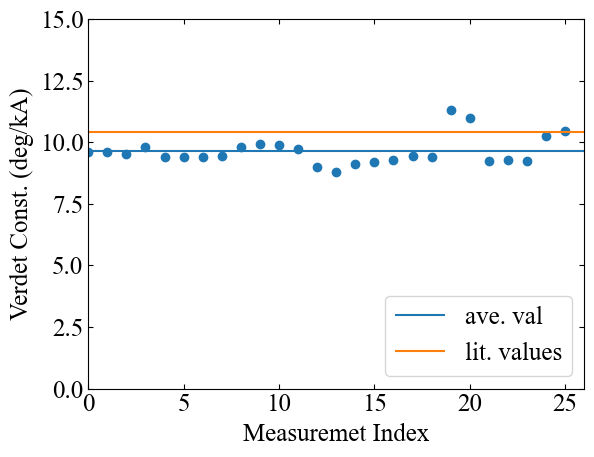

9.630332967072528


In [88]:
print(plot_verdet(True))

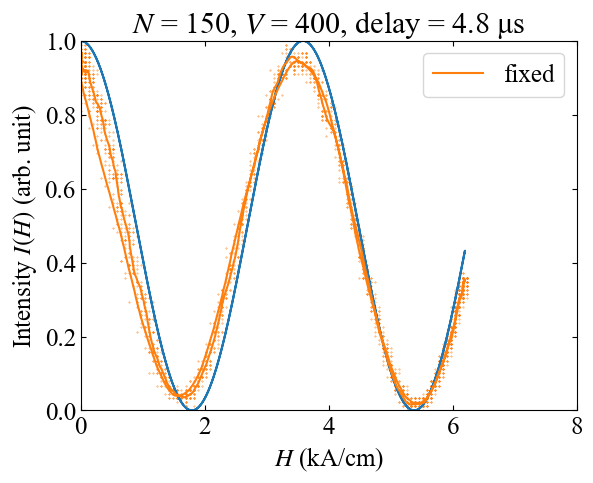

In [24]:
def plot_xy_graph_0(index=0):
    f = plt.figure()

    ax1 = f.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax1.set_xlim(0,8)
    ax1.set_ylim(0,1.0)

    ax1.set_xlabel("$H$ (kA/cm)")
    ax1.set_ylabel("Intensity $I(H)$ (arb. unit)")

    shift = get_shift(Ns[index])

    def fu(x, a):
        y = np.cos(a*x)**2
        return y
    popt, pcov = curve_fit(fu, H_field_smooth[index][:2500-shift], Intensity_smooth[index][shift:])
    ax1.plot(H_field_smooth[index],fu(H_field_smooth[index], *popt), c = "tab:green", label = "fitting")

    ax1.plot(H_field_smooth[index][:2500-shift], Intensity_smooth[index][shift:], c = "tab:orange", label = "fixed")
    ax1.scatter(H_field[index][:2500-shift], Intensity[index][shift:], s = 0.1, c = "tab:orange")

    plt.title(f"$N$ = {Ns[index]}, $V$ = {Vs[index]}, delay = {shift*dt:1.1f} μs")

    plt.legend(loc = "upper right")

    plt.show()

plot_xy_graph_0()

#### 磁化の応答の遅れを見る

In [ ]:
def plot_xy_graph_shift(index):
    font_size = 18
    f = plt.figure()

    ax1 = f.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax1.set_xlim(0,8)
    ax1.set_ylim(0,1.0)

    ax1.set_xlabel("$H$ (kA/cm)")
    ax1.set_ylabel("Intensity (arb. unit)")
    plt.title(f"$N$ = {Ns[index]}, $V$ = {Vs[index]}")
    ims = []

    shift = get_shift(Ns[index])
    ax1.plot(H_field_smooth[index][:2500-shift], Intensity_smooth[index][shift:], c = "tab:orange", label = "fixed")
    ax1.scatter(H_field[index][:2500-shift], Intensity[index][shift:], s = 0.1, c = "tab:orange")

    for shift in range(31):
        plt.tight_layout()
        line, = ax1.plot(H_field_smooth[index][:2500-shift], Intensity_smooth[index][shift:], c = "tab:blue")
        points = ax1.scatter(H_field[index][:2500-shift], Intensity[index][shift:], s =0.2, c = "tab:blue")
        ims.append([line, points, ax1.text(4.8,0.9, f"delay time = {shift*dt:.1f} μs")])
    del shift

    folder_path = f"../image/xy_shift/"
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    #アニメの生成
    ani = animation.ArtistAnimation(f, ims, interval=100, blit=True, repeat_delay=1000)
    ani.save(folder_path+f"{index+1:02}.gif", writer="pillow")
    # plt.savefig(f"../image/xy_test/{index+1:02}/shift{shift:02}.png",  bbox_inches='tight')
    plt.close()

for i in range(nfile):
    plot_xy_graph_shift(i)
del i


In [ ]:
def plot_xt_graph_shift(index):
    font_size = 18
    f = plt.figure()

    ax1 = f.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax1.set_xlim(-50,450)
    ax1.set_ylim(0,1.0)

    plt.title(f"$N$ = {Ns[index]}, $V$ = {Vs[index]}")

    ax1.set_xlabel("Time $t$ ($\mathrm{\mu s}$)")
    ax1.set_ylabel("Intensity $I(t)$ (arb. unit)")

    ax2 = ax1.twinx()
    ax2.set_ylim(0,8.0)
    ax2.set_ylabel("Magnetic field $H(t)$ (kA/cm)")
    ax2.plot(Time, H_field_smooth[index], c = "tab:orange")
    ax2.scatter(Time, H_field[index], s =0.2, c = "tab:orange")

    ims = []
    for i in range(31):
        shift = i * 5
        plt.tight_layout()
        line1, = ax1.plot(Time[:2500-shift], Intensity_smooth[index][shift:], c = "tab:blue")
        points1 = ax1.scatter(Time[:2500-shift], Intensity[index][shift:], s =0.2, c = "tab:blue")
        txt = ax1.text(200,0.9, f"delay time = {shift*dt:2.1f} μs", backgroundcolor="white")
        txt.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))
        ims.append([line1, points1, txt])

    folder_path = f"../image/xt_shift/"
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    #アニメの生成
    ani = animation.ArtistAnimation(f, ims, interval=100, blit=True, repeat_delay=1000)
    ani.save(folder_path+f"{index+1:02}.gif", writer="pillow")
    # plt.savefig(f"../image/xy_test/{index+1:02}/shift{shift:02}.png",  bbox_inches='tight')
    plt.close()

# plot_xt_graph_shift(0)

for i in range(nfile):
    plot_xt_graph_shift(i)
del i


## アニメーションを作るときの参考

参考 https://zerofromlight.com/blogs/detail/100/
```
y = [0] * 30
# yの10, 11, 12, 13, 14, 15, 16番目の要素を変更
y[10], y[11], y[12], y[13], y[14], y[15], y[16] = 0.05, -0.05, 0.05, -0.05, 0.05, -0.05, 0.4

x_data = []
y_data = []
artist_list = []

fig, ax = plt.subplots()

for index, i in enumerate(y):
    ax.set_xlim(0, 30)
    ax.set_ylim(-1, 1)
    x_data.append(index)
    y_data.append(i)
    line, = ax.plot(x_data, y_data)
    title = ax.text(0, 1.05, 'ArtistAnimation: {}'.format(index), fontsize=15) # 追加
    artist_list.append([line, title]) # リスト内にtitleを追加


ani = animation.ArtistAnimation(
    fig=fig,
    artists=artist_list,
    interval=100,
)
#保存
ani.save("sample.gif", writer="pillow")
plt.close()
```